In [2]:
import sqlite3
import pandas as pd
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

In [3]:
path = "/Users/davidemomi/Desktop/DAVE/summerscholl_viterbo/summerschool/project/"  #Insert path here
database = path + 'database.sqlite'
conn = sqlite3.connect(database)

#Defining the number of jobs to be run in parallel during grid search
n_jobs = 1 #Insert number of parallel jobs here

#Fetching required data tables
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
matches = pd.read_sql("SELECT * FROM Match;", conn)

In [4]:
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...
8,table,Match_Player_Attributes,Match_Player_Attributes,305672,CREATE TABLE Match_Player_Attributes (`match_i...


In [5]:
print(player_stats_data)

            id  player_fifa_api_id  player_api_id                 date  \
0            1              218353         505942  2016-02-18 00:00:00   
1            2              218353         505942  2015-11-19 00:00:00   
2            3              218353         505942  2015-09-21 00:00:00   
3            4              218353         505942  2015-03-20 00:00:00   
4            5              218353         505942  2007-02-22 00:00:00   
5            6              189615         155782  2016-04-21 00:00:00   
6            7              189615         155782  2016-04-07 00:00:00   
7            8              189615         155782  2016-01-07 00:00:00   
8            9              189615         155782  2015-12-24 00:00:00   
9           10              189615         155782  2015-12-17 00:00:00   
10          11              189615         155782  2015-10-16 00:00:00   
11          12              189615         155782  2015-09-25 00:00:00   
12          13              189615    

In [7]:
playerAttributes=player_stats_data
#Cleaning the Player  Attributes table
#Drop some columns from the player attributes table 
toDrop = ['overall_rating', 'attacking_work_rate', 'volleys']
newPlayerAttributes = playerAttributes.dropna(axis=0, how='any', thresh=None, subset=toDrop, inplace=False)

In [8]:
print(newPlayerAttributes)

            id  player_fifa_api_id  player_api_id                 date  \
0            1              218353         505942  2016-02-18 00:00:00   
1            2              218353         505942  2015-11-19 00:00:00   
2            3              218353         505942  2015-09-21 00:00:00   
3            4              218353         505942  2015-03-20 00:00:00   
4            5              218353         505942  2007-02-22 00:00:00   
5            6              189615         155782  2016-04-21 00:00:00   
6            7              189615         155782  2016-04-07 00:00:00   
7            8              189615         155782  2016-01-07 00:00:00   
8            9              189615         155782  2015-12-24 00:00:00   
9           10              189615         155782  2015-12-17 00:00:00   
10          11              189615         155782  2015-10-16 00:00:00   
11          12              189615         155782  2015-09-25 00:00:00   
12          13              189615    

In [11]:
#get the numerical data
data=newPlayerAttributes
def handle_non_numerical_data(data):
    columns = data.columns.values
    
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]
        
        if data[column].dtype != np.int64 and data[column].dtype != np.float64:
            column_contents = data[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x += 1
            data[column] = list(map(convert_to_int, data[column]))
    return data

data = handle_non_numerical_data(data)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
print(data)

            id  player_fifa_api_id  player_api_id  date  overall_rating  \
0            1              218353         505942   105            67.0   
1            2              218353         505942   144            67.0   
2            3              218353         505942   110            62.0   
3            4              218353         505942   119            61.0   
4            5              218353         505942    52            61.0   
5            6              189615         155782    42            74.0   
6            7              189615         155782    79            74.0   
7            8              189615         155782    78            73.0   
8            9              189615         155782    87            73.0   
9           10              189615         155782    91            73.0   
10          11              189615         155782   181            73.0   
11          12              189615         155782    38            74.0   
12          13           

In [14]:
#then normalized the data
from sklearn import preprocessing
#MinMax scaler, it does not distort data
mm_scaler = preprocessing.MinMaxScaler()
mm_scaled_x_train = mm_scaler.fit_transform(data)

#Standard Scaler in case of the normal distribution
std_scaler = preprocessing.StandardScaler()
std_scaled_data = std_scaler.fit_transform(data)

#Normalization of the data processed by Standard Scaler
normalized_std_data = preprocessing.normalize(std_scaled_data)

In [18]:
for col in data.columns: 
    print(col) 

id
player_fifa_api_id
player_api_id
date
overall_rating
potential
preferred_foot
attacking_work_rate
defensive_work_rate
crossing
finishing
heading_accuracy
short_passing
volleys
dribbling
curve
free_kick_accuracy
long_passing
ball_control
acceleration
sprint_speed
agility
reactions
balance
shot_power
jumping
stamina
strength
long_shots
aggression
interceptions
positioning
vision
penalties
marking
standing_tackle
sliding_tackle
gk_diving
gk_handling
gk_kicking
gk_positioning
gk_reflexes


In [20]:
df = pd.DataFrame(normalized_std_data, columns = data.columns)

In [21]:
print(df)

              id  player_fifa_api_id  player_api_id      date  overall_rating  \
0      -0.325033            0.183002       0.502076  0.012528       -0.043649   
1      -0.321796            0.181181       0.497081  0.141267       -0.043214   
2      -0.320219            0.180295       0.494651  0.028783       -0.174486   
3      -0.312353            0.175868       0.482505  0.056942       -0.195852   
4      -0.309014            0.173990       0.477352 -0.156262       -0.193761   
5      -0.299015            0.074469       0.022737 -0.181911        0.131736   
6      -0.300795            0.074913       0.022873 -0.068713        0.132521   
7      -0.306219            0.076265       0.023286 -0.073097        0.109764   
8      -0.306915            0.076439       0.023339 -0.044899        0.110015   
9      -0.307061            0.076476       0.023350 -0.032308        0.110068   
10     -0.296913            0.073950       0.022579  0.243170        0.106432   
11     -0.297897            

In [68]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

A = df 
for k in range (1, 21):
     # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(A.iloc[:, :])

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = kmeans_model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = kmeans_model.inertia_
    print("k:",k, " cost:", interia)
    
    
 
print("")

k: 1  cost: 178392.41013843272
k: 2  cost: 144626.3559712018
k: 3  cost: 128214.62529766273
k: 4  cost: 118604.52050755064
k: 5  cost: 111187.212037825
k: 6  cost: 107551.3349203424
k: 7  cost: 104359.70705658448
k: 8  cost: 101629.57976602908
k: 9  cost: 99400.99315725932
k: 10  cost: 97529.37884869617
k: 11  cost: 95684.37439026595
k: 12  cost: 94258.53027672542
k: 13  cost: 92933.73048258385
k: 14  cost: 91678.08760111309
k: 15  cost: 90752.05627655494
k: 16  cost: 89543.19995843308
k: 17  cost: 88447.44911528328
k: 18  cost: 87607.72994440656
k: 19  cost: 86846.43821287867
k: 20  cost: 86047.64883507



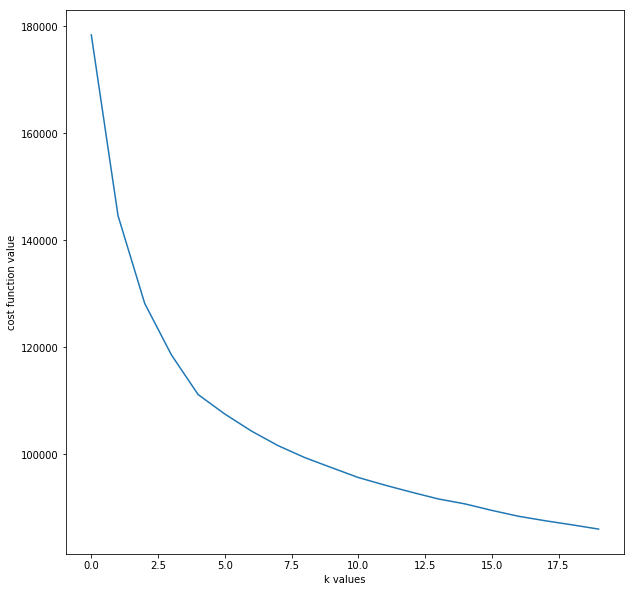

In [81]:
import matplotlib.pyplot as plt


x = [178392.41013843272, 144626.3559712018, 128214.62529766273, 118604.52050755064, 111187.212037825, 107551.3349203424, \
     104359.70705658448, 101629.57976602908, 99400.99315725932, 97529.37884869617, 95684.37439026595, 94258.53027672542, \
     92933.73048258385, 91678.08760111309, 90752.05627655494, 89543.19995843308, 88447.44911528328, 87607.72994440656, \
     86846.43821287867, 86047.64883507]
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(x)
plt.xlabel('k values')
plt.ylabel('cost function value')
plt.savefig('image.jpg')

In [58]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(A)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [59]:
print(kmeans.labels_)

[0 0 0 ... 1 1 1]


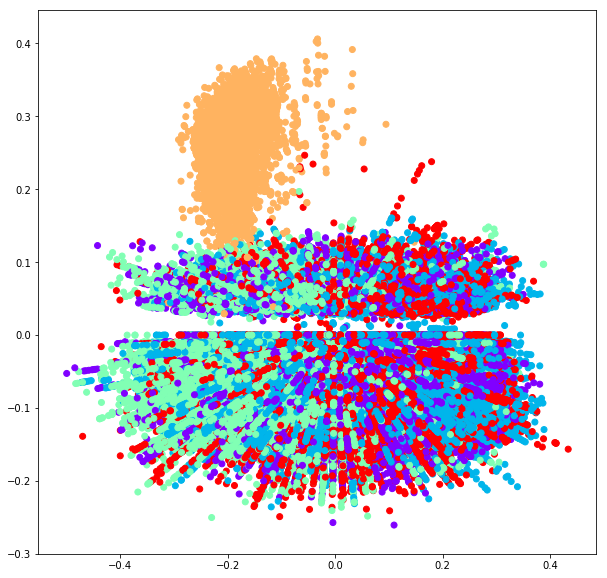

In [83]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(A.iloc[:,11],A.iloc[:,40], c=kmeans.labels_, cmap='rainbow')
plt.savefig('k_means.jpg')